In [3]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


In [4]:
# Load the weather dataset (update the filename if needed)
df = pd.read_csv("weatherHistory.csv")  

In [6]:
# Display first 5 rows
print("Dataset Preview:")
print(df.head())

Dataset Preview:
                  Formatted Date        Summary Precip Type  Temperature (C)  \
0  2006-04-01 00:00:00.000 +0200  Partly Cloudy        rain         9.472222   
1  2006-04-01 01:00:00.000 +0200  Partly Cloudy        rain         9.355556   
2  2006-04-01 02:00:00.000 +0200  Mostly Cloudy        rain         9.377778   
3  2006-04-01 03:00:00.000 +0200  Partly Cloudy        rain         8.288889   
4  2006-04-01 04:00:00.000 +0200  Mostly Cloudy        rain         8.755556   

   Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
0                  7.388889      0.89            14.1197   
1                  7.227778      0.86            14.2646   
2                  9.377778      0.89             3.9284   
3                  5.944444      0.83            14.1036   
4                  6.977778      0.83            11.0446   

   Wind Bearing (degrees)  Visibility (km)  Loud Cover  Pressure (millibars)  \
0                   251.0          15.8263         0.0       

In [ ]:
# Show dataset information
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB
None


In [9]:
# Select important features for forecasting
# 'Temperature (C)', 'Humidity', 'Wind Speed (km/h)'
features = ['Temperature (C)', 'Humidity', 'Wind Speed (km/h)']
df_filtered = df[features]

# Convert to numpy array
data = df_filtered.values

# Scale all features between 0 and 1 (important for RNNs)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

print("Scaled Data Shape:", scaled_data.shape)


Scaled Data Shape: (96453, 3)


In [11]:
# Function to create input sequences and corresponding labels
def create_sequences(dataset, time_step=30):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:i+time_step])        # past 'time_step' days as input
        y.append(dataset[i+time_step][0])       # next day's temperature as output
    return np.array(X), np.array(y)

# Use past 30 days to predict the next day
time_step = 30
X, y = create_sequences(scaled_data, time_step)

# Train-Test Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print("Training set shape:", X_train.shape) 
print("Testing set shape:", X_test.shape)


Training set shape: (77138, 30, 3)
Testing set shape: (19285, 30, 3)


In [12]:
# Build an LSTM model
model = Sequential()

# First LSTM layer
model.add(LSTM(64, return_sequences=True, input_shape=(time_step, len(features))))

# Second LSTM layer
model.add(LSTM(32, return_sequences=False))

# Dense layers for learning
model.add(Dense(16, activation='relu'))
model.add(Dense(1))  # Output: next day's temperature

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
model.summary()


C:\Users\Aziz\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,           # number of passes over the dataset
    batch_size=32,       # how many samples per gradient update
    verbose=1
)


Epoch 1/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 55s 21ms/step - loss: 0.0033 - val_loss: 3.5878e-04
Epoch 2/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 46s 19ms/step - loss: 5.5131e-04 - val_loss: 3.3895e-04
Epoch 3/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 45s 19ms/step - loss: 5.1763e-04 - val_loss: 3.1384e-04
Epoch 4/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 46s 19ms/step - loss: 5.0652e-04 - val_loss: 3.7866e-04
Epoch 5/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 46s 19ms/step - loss: 4.8273e-04 - val_loss: 3.0995e-04
Epoch 6/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 48s 20ms/step - loss: 4.6655e-04 - val_loss: 3.0302e-04
Epoch 7/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 46s 19ms/step - loss: 4.5867e-04 - val_loss: 2.8702e-04
Epoch 8/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - loss: 4.6402e-04 - val_loss: 2.8489e-04
Epoch 9/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 45s 19ms/step - loss: 4.5343e-04 - val_loss: 3.3716e-04
Epoch 10/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 43s 18ms/step - loss: 4.4655e-04 - val_loss: 3.1278e-04
Epoch 11/20
2411/2411 ━

In [14]:
# Evaluate on training and testing data
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

print(f"Training Loss (MSE): {train_loss:.4f}")
print(f"Testing Loss (MSE):  {test_loss:.4f}")


Training Loss (MSE): 0.0004
Testing Loss (MSE):  0.0003


In [15]:
# Predict on test set
predictions = model.predict(X_test)

# Extract only the temperature scaler for inverse transformation
temp_scaler = MinMaxScaler()
temp_scaler.min_, temp_scaler.scale_ = scaler.min_[0], scaler.scale_[0]

# Rescale predictions and actual values back to original temperature scale
predictions_rescaled = temp_scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_rescaled = temp_scaler.inverse_transform(y_test.reshape(-1, 1))


603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


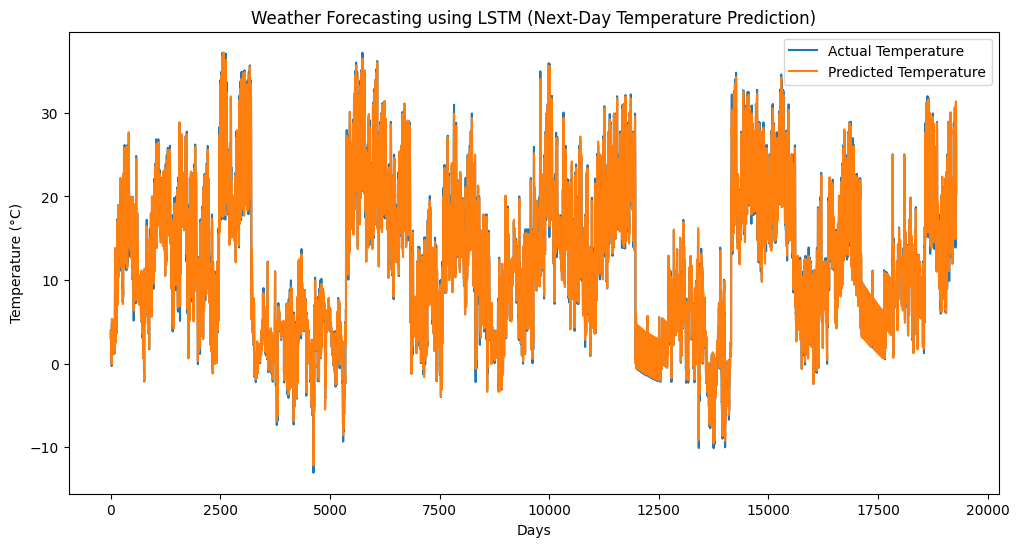

In [16]:
# Plot actual vs predicted temperatures
plt.figure(figsize=(12,6))
plt.plot(y_test_rescaled, label="Actual Temperature")
plt.plot(predictions_rescaled, label="Predicted Temperature")
plt.title("Weather Forecasting using LSTM (Next-Day Temperature Prediction)")
plt.xlabel("Days")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()


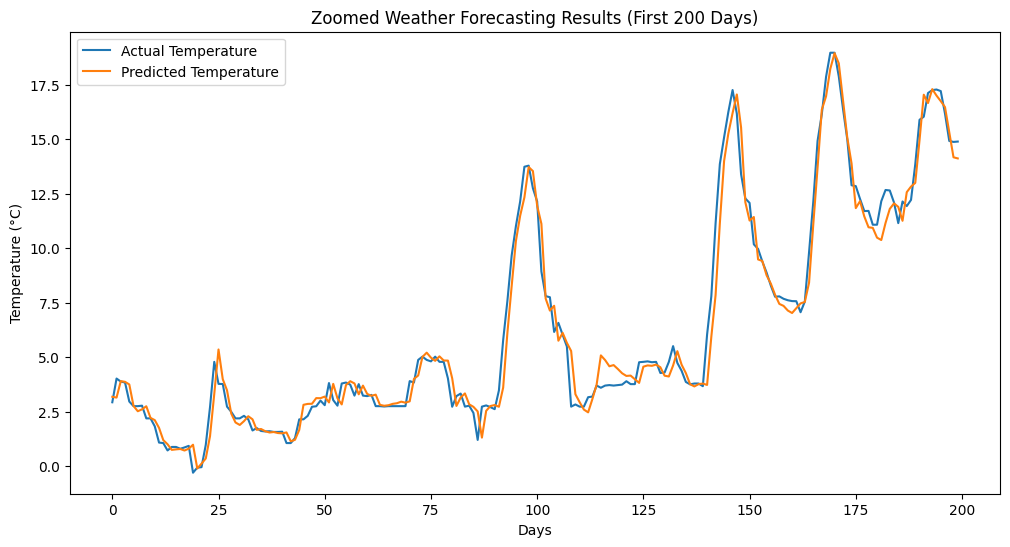

In [18]:
# Zoomed-in view of first 200 test samples
plt.figure(figsize=(12,6))
plt.plot(y_test_rescaled[:200], label="Actual Temperature")
plt.plot(predictions_rescaled[:200], label="Predicted Temperature")
plt.title("Zoomed Weather Forecasting Results (First 200 Days)")
plt.xlabel("Days")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()


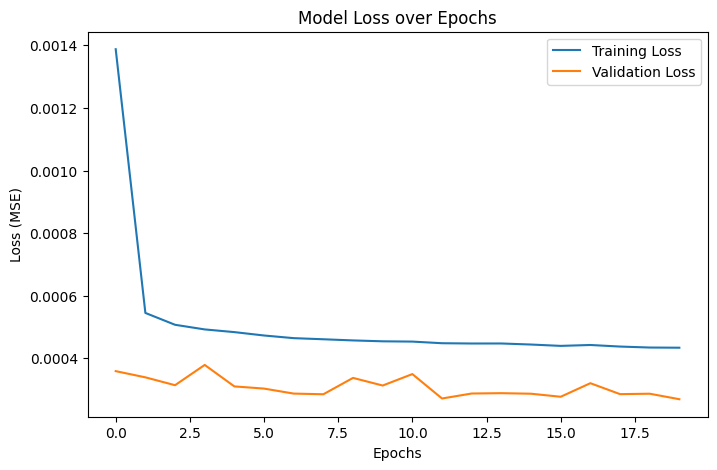

In [19]:
# Plot training and validation loss over epochs
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Model Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()
